In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix
import nltk
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
lm=WordNetLemmatizer()
from nltk.corpus import stopwords
stop=set(stopwords.words("English"))
import re
from sklearn.naive_bayes import MultinomialNB
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data=pd.read_csv(r"amazon_alexa.tsv",delimiter='\t',quoting=3)
data.shape

(3150, 5)

In [3]:
data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1


In [4]:
print("feature name",data.columns.values )

feature name ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
data[data['verified_reviews'].isna()==True] #Check on which line which nan valueis there

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
data.dropna(inplace=True) #Drop null value 

In [8]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [9]:
data.shape

(3149, 5)

In [10]:
data['Length']=data['verified_reviews'].apply(len)
data

,rating,date,variation,verified_reviews,feedback,Length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
Length               int64
dtype: object

In [12]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

We will be creating positive & negative sentimental anlaysis

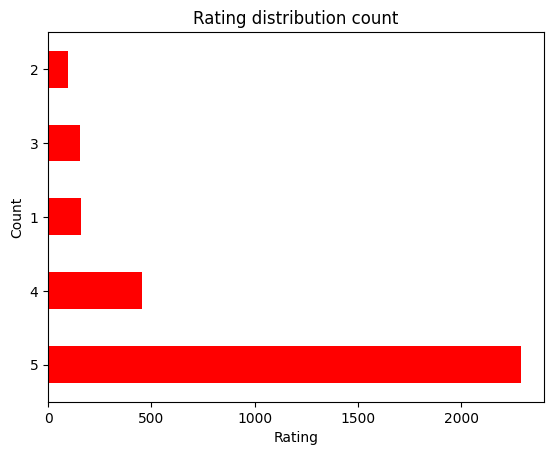

In [13]:
data['rating'].value_counts().plot.barh(color='red')
plt.title('Rating distribution count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [14]:
print(f"Percentage of every review \n{round(data['rating'].value_counts()/data.shape[0]*100,2)} ")

Percentage of every review 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64 


In [15]:
data['feedback'].value_counts() #1 ->Positive feedback , 0 is negative feedback

feedback
1    2893
0     256
Name: count, dtype: int64

In [16]:
print(data[data['feedback']==0].iloc[0]['verified_reviews'])


"It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals."


In [17]:
print(data[data ['feedback']==1].iloc[1]['verified_reviews'])

Loved it!


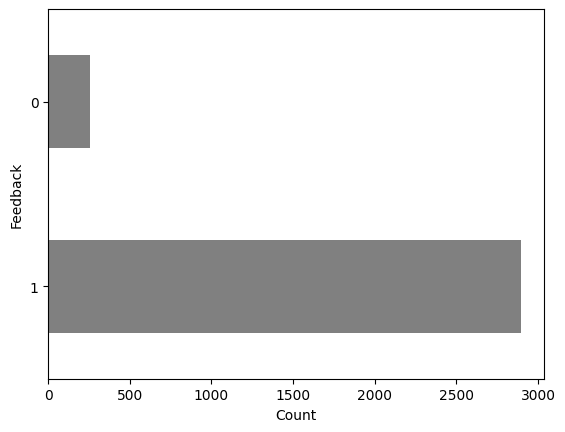

In [18]:
data['feedback'].value_counts().plot.barh(color='grey')
plt.xlabel('Count')
plt.ylabel('Feedback')
plt.show()

In [19]:
print(round(data['feedback'].value_counts()/data.shape[0]*100,2))

feedback
1    91.87
0     8.13
Name: count, dtype: float64


In [20]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

from above outcome we observe that the customer who has given feedback 0 they have given either 1 or 2 rating

In [21]:
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

from above outcome we observe that the customer who has given feedback 1 they have given 3,4 or 5 rating

In [22]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

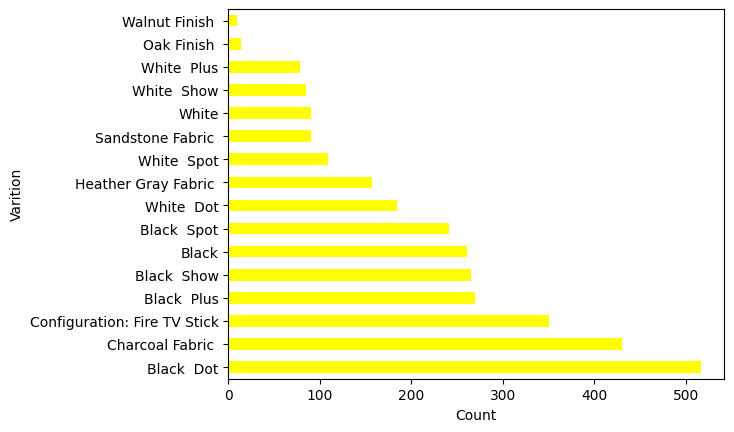

In [23]:
data['variation'].value_counts().plot.barh(color='yellow')
plt.xlabel('Count')
plt.ylabel('Varition')
plt.show()

In [24]:
print(round(data['variation'].value_counts()/data.shape[0]*100,2))

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


[Text(0.5, 1.0, 'Distribution of length of review')]

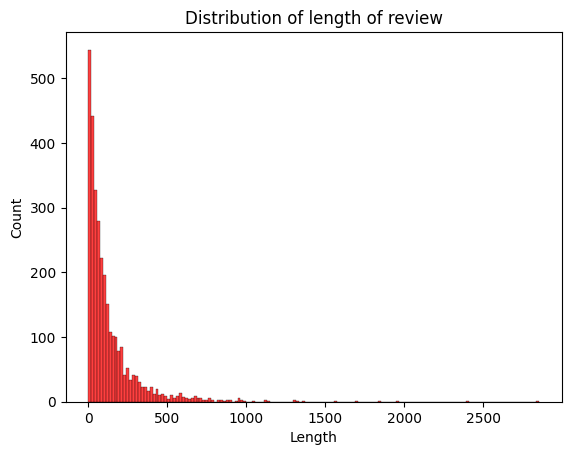

In [25]:
sns.histplot(data['Length'], color='red').set(title="Distribution of length of review")

[Text(0.5, 1.0, 'This is graph')]

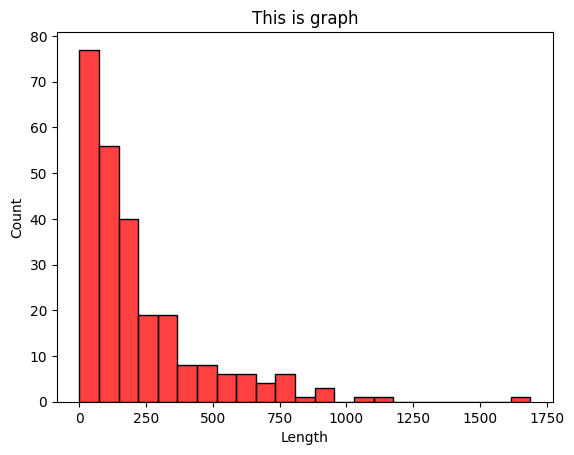

In [26]:
sns.histplot(data[data['feedback']==0]['Length'],color='red').set(title="This is graph")

[Text(0.5, 1.0, 'This is graph')]

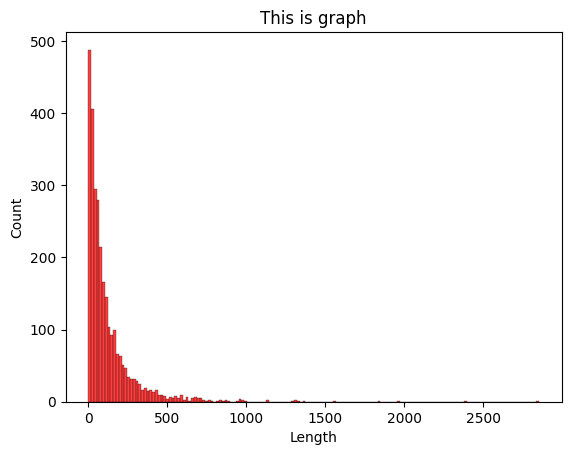

In [27]:
sns.histplot(data[data['feedback']==1]['Length'],color='red').set(title="This is graph")

In [28]:
corpus=[]
for i in range(0, data.shape[0]):
    review=re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
    review=review.lower().split()
    review=[lm.lemmatize(word) for word in review if not word in stop]
    review=' '.join(review)
    corpus.append(review)

In [29]:
corpus

['love echo',
 'loved',
 'sometimes playing game answer question correctly alexa say got wrong answer like able turn light away home',
 'lot fun thing yr old learns dinosaur control light play game like category nice sound playing music well',
 'music',
 'received echo gift needed another bluetooth something play music easily accessible found smart speaker wait see else',
 'without cellphone cannot use many feature ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep fun ask random question hear response seem smartbon politics yet',
 'think th one purchased working getting one every room house really like feature offer specifily playing music echo controlling light throughout house',
 'look great',
 'love listened song heard since childhood get news weather information great',
 'sent year old dad talk constantly',
 'love learning knew thing eveyday still figuring everything work far easy use understand make laugh time',
 'purchased mother knee prob

In [30]:
data['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    "Sometimes while playing a game, you can answe...
3    "I have had a lot of fun with this thing. My 4...
4                                                Music
Name: verified_reviews, dtype: object

In [31]:
#cv=TfidfVectorizer(max_features=2500)
X=corpus
y=data['feedback'].values

In [32]:
pipeline = Pipeline([
    ('vector' , TfidfVectorizer(max_features=2500)),
    ('rf', MultinomialNB(class_prior=[0.5, 0.5]))
])

In [33]:
X_train, X_test , y_train , y_test=train_test_split(X , y , random_state=43, test_size=0.4 )
pipeline.fit(X_train, y_train)

,steps,"[('vector', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [34]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

As we can see above that for lass 1 & 0 data is imbalance. In such scenario instead of accuarcy precision , recall & f1 score would be the right metrics 

In [35]:
pipeline.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [36]:
print("Training Accuracy:",pipeline.score(X_train , y_train))
print("Testing Accuracy:",pipeline.score(X_test , y_test))

Training Accuracy: 0.9354155637903653
Testing Accuracy: 0.9031746031746032


In [37]:
y_pred=pipeline.predict(X_test)

In [38]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.47      0.37      0.41       117
           1       0.94      0.96      0.95      1143

    accuracy                           0.90      1260
   macro avg       0.70      0.66      0.68      1260
weighted avg       0.89      0.90      0.90      1260



In [40]:
pickle.dump(pipeline, open("sentiment_pipeline.pkl", "wb"))

In [44]:
p_model=pickle.load(open ('sentiment_pipeline.pkl', 'rb'))

In [50]:
text = ["Great"]
print(p_model.predict(text))

[1]
